# Micro-narrative analysis of _Reddit comments after ChatGPT launch_

Start with the notebook about _Lord of the Rings_ before going through this!

We roughly try to replicate the analysis, but jump some hoops where things differ.

In [1]:
import os
from datetime import date

import pandas as pd

data = pd.read_json("input/chatgpt-reddit-comments.jsonl", lines=True)

data.head()

subreddit_id  approved_at_utc  author_is_blocked  comment_type  edited  \
0    t5_7hqomg              NaN              False           NaN       0   
1    t5_7hqomg              NaN              False           NaN       0   
2    t5_7hqomg              NaN              False           NaN       0   
3    t5_7hqomg              NaN              False           NaN       0   
4    t5_7hqomg              NaN              False           NaN       0   

   mod_reason_by  banned_by   ups  num_reports author_flair_type  ...  \
0            NaN        NaN  1229          NaN              text  ...   
1            NaN        NaN   246          NaN              text  ...   
2            NaN        NaN    62          NaN              text  ...   
3            NaN        NaN    87          NaN               NaN  ...   
4            NaN        NaN    13          NaN               NaN  ...   

   subreddit_name_prefixed controversiality author_flair_background_color  \
0                r/ChatGPT                0                          None   
1                r/ChatGPT                0                          None   
2                r/ChatGPT                0                          None   
3                r/ChatGPT                0                                 
4                r/ChatGPT                0                                 

   collapsed_because_crowd_control mod_reports mod_note  distinguished  \
0                              NaN          []      NaN           None   
1                              NaN          []      NaN           None   
2                              NaN          []      NaN           None   
3                              NaN          []      NaN           None   
4                              NaN          []      NaN           None   

  media_metadata  author_cakeday  editable  
0            NaN             NaN       NaN  
1            NaN             NaN       NaN  
2            NaN             NaN       NaN  
3            NaN             NaN       NaN  
4            NaN             NaN       NaN  

[5 rows x 72 columns]

In [2]:
docs = data["body"]
ids = data["id"]
categories = data["subreddit"]
timestamps = [date.fromtimestamp(d) for d in data["created_utc"]]
metadata_keys = ['author', 'score', 'parent_id']
metadata = data[metadata_keys].to_dict(orient='records')

In [6]:
from narrativegraphs import CooccurrenceGraph
from narrativegraphs.nlp.entities import SpacyEntityExtractor
from narrativegraphs.nlp.mapping import SubgramStemmingMapper

if os.path.exists("chatgpt_reddit.db"):
    model = CooccurrenceGraph.load("chatgpt_reddit.db")
else:
    model = CooccurrenceGraph(
        entity_extractor=SpacyEntityExtractor(
            model_name="en_core_web_lg", # bigger model
            named_entities=True, # accept all named entities
            noun_chunks=(2, None)  # only two word NPs and bigger
        ),
        entity_mapper=SubgramStemmingMapper(
            head_word_type="noun",
            min_subgram_length=2,  # avoids single word entities sucking up everything
            min_subgram_frequency=2,  # also for rare entities
            min_subgram_frequency_ratio=2,  # twice as frequent to be canonical
        ),
        sqlite_db_path="chatgpt_reddit.db",
        n_cpu=-1
    ).fit(docs, doc_ids=ids, categories=categories, timestamps=timestamps, metadata=metadata)

INFO:narrativegraphs.pipeline:Adding 52412 documents to database
INFO:narrativegraphs.pipeline:Extracting entities


Extracting entities:   0%|          | 0/52412 [00:00<?, ?it/s]

INFO:narrativegraphs.nlp.extraction:Using multiple CPU cores. Progress may stand still at first.
INFO:narrativegraphs.pipeline:Resolving entities
INFO:narrativegraphs.pipeline:Mapping tuplets
INFO:narrativegraphs.pipeline:Calculating stats


In [ ]:
model.serve_visualizer()

## PMI weighting of entity cooccurrences

We ensure that PMI shows the same properties in this corpus as in LotR.

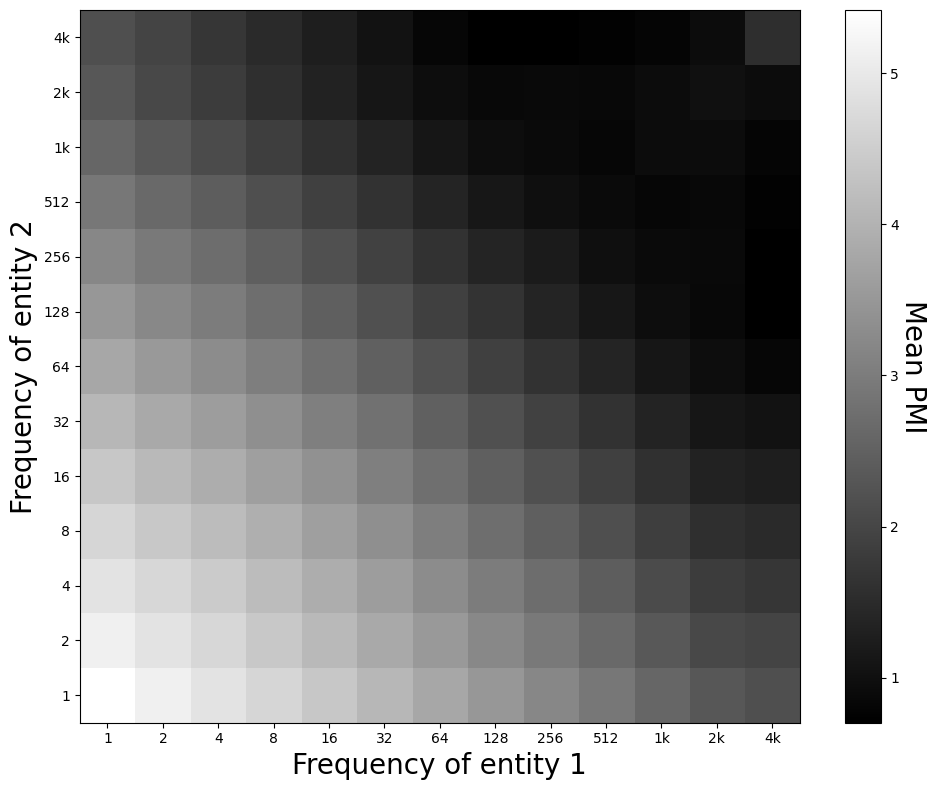

In [10]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

Roughly the same picture as for LotR, but there is a potential anomaly in the top right corner: some high frequent entities seem to be highly associated. Let us see what they are!

In [11]:
df = model.cooccurrences_
df[(df.entity_one_frequency >= 1000) & (df.entity_two_frequency >= 1000)].sort_values(by="pmi", ascending=False)

id entity_one  entity_one_frequency entity_two  \
8871    8872     Google                  2238     Google   
1329    1330     AI\n\n                  5899     AI\n\n   
18321  18322   any ways                  1363   any ways   
1668    1669  both lots                  1395  both lots   
5847    5848     AI\n\n                  5899   any ways   
88785  88786  both lots                  1395     Google   
7716    7717     AI\n\n                  5899     Google   
27074  27075     AI\n\n                  5899  both lots   
34387  34388   any ways                  1363     Google   
30741  30742   any ways                  1363  both lots   

       entity_two_frequency  frequency  doc_frequency  adjusted_tf_idf  \
8871                   2238        682            336    105912.676558   
1329                   5899       1928            812    124228.688807   
18321                  1363        101             66     78226.865672   
1668                   1395         99             83     61147.333333   
5847                   1363        334            196     88594.903553   
88785                  2238        112             70     81939.887324   
7716                   2238        441            221    103879.639640   
27074                  1395        265            179     76870.933333   
34387                  2238         90             62     74042.349206   
30741                  1395         38             36     52412.000000   

      first_occurrence last_occurrence       pmi  entity_one_id  \
8871        2022-12-05      2023-01-28  1.553443            711   
1329        2022-12-04      2023-01-29  1.162929             93   
18321       2022-12-04      2023-01-27  1.154709            212   
1668        2022-12-06      2023-01-27  1.125866            280   
5847        2022-12-04      2023-01-29  1.037851             93   
88785       2022-12-07      2023-01-26  0.974163            280   
7716        2022-12-04      2023-01-28  0.943179             93   
27074       2022-12-06      2023-01-28  0.927272             93   
34387       2022-12-04      2023-01-28  0.889266            212   
30741       2022-12-08      2023-01-28  0.720093            212   

       entity_two_id                                           category  
8871             711  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
1329              93  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
18321            212  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
1668             280  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
5847             212  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
88785            711  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
7716             711  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
27074            280  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
34387            711  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...  
30741            280  [ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ...

Not high PMIs, but noticeable, between some highly frequent entities in the discourse like tech giants, _GPT_ and some generic high frequent entities like _the way_.

In [62]:
min_weight = 2.5

## Community detection

We will try to replicate the settings from the other analysis, but since the corpus is much bigger, we may have to adapt some hyperparameters.

In [63]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_node_frequency=2
)

In [64]:
k_clique_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=min_weight,
    community_detection_method_args=dict(k=4)
)
k_clique_comms_with_contexts = []
k_clique_big_comms = []

for comm in sorted(k_clique_comms, key=lambda c: c.score, reverse=True):
    size = len(comm.members)
    if size < 2:
        continue
    if size > 100:
        k_clique_big_comms.append(comm)
        continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    k_clique_comms_with_contexts.append((comm, contexts))

In [65]:
docs = model.documents_
doc_id_to_timestamp = {
    doc_id: timestamp
    for doc_id, timestamp in zip(docs.id, docs.timestamp)
}

In [66]:
spike_values, spread_values = [], []
for comm, contexts in k_clique_comms_with_contexts:
    ids = {c.doc_id for c in contexts}
    spike_values.append(len(ids))
    dates = [doc_id_to_timestamp[context.doc_id] for context in contexts]
    spread_values.append((max(dates) - min(dates)).days + 1)

    
single_spike_count = sum(1 for sv in spike_values if sv == 1)
print('Single spike count:', single_spike_count, 'out of total', len(k_clique_comms_with_contexts))

Single spike count: 3798 out of total 7134


In [41]:
from sharedutils import print_comm_with_contexts

single_spiked_comms = []

for (comm, contexts), sv in zip(k_clique_comms_with_contexts, spike_values):
    if sv > 1: continue
    single_spiked_comms.append((comm, contexts))
    print_comm_with_contexts(comm, contexts)

COMMUNITY: 7 colours, rainbow colours, the rainbow, RGB
ID: 33389, OFFSET: 0
Hah I asked ChatGPT which colours are in the rainbow, it named 7, then I asked it for the RGB codes for them, and it gave me 6, then I said you only gave me 6 RGB codes and it said yeah these are the 6 RGB codes. I said but you told me there are 7 colours in the rainbow, and I recited them back to ChatGPT. It said that's right, there are 7 colours in the rainbow. I said but when I asked you for the RGB codes for the rainbow colours you gave me 6. It said that's right these are the six RGB codes for the rainbow colours.

There's a long way to go trusting AI if it can't even count to 7. Even if it starts generating spreadsheets, someone with knowledge of spreadsheets and the domain knowledge of whatever is being used in the spreadsheets is going to have to check it.

COMMUNITY: CTO, the c-suite, a wildcard, CRO
ID: 39653, OFFSET: 0
She/he means it as a wildcard, really C*O

Anyone from the c-suite: CEO, COO, CRO

Many appear meaningful in the context of ChatGPT discussions, others less so.

The nature of the data is quite different from a literary work. Their ordering is very different since their are comments from a thread, and we have currently detached them from their immediate context. Be that as it may, at least for now, we may be able to see whether and how the comments connect to the general topic, namely ChatGPT and large language models.

In [30]:
top_500 = model.entities_.sort_values(by="doc_frequency", ascending=False)[:500]
top_500_entity_ids = set(top_500.id)

In [31]:
from tqdm.auto import tqdm

def connection_score(comm):
    graph_context = model.graph.expand_from_focus_entities(comm.member_ids, "cooccurrence")
    top_connected = sum(1 for node in graph_context.nodes
                        if node.id in top_500_entity_ids)
    return top_connected / len(comm.members)

connection_scores = [connection_score(comm) for comm, _ in tqdm(single_spiked_comms)]

  0%|          | 0/3227 [00:00<?, ?it/s]

ERROR:sqlalchemy.pool.impl.QueuePool:Error closing cursor
Traceback (most recent call last):
  File "/Users/au479461/PycharmProjects/narrative-graph/.venv/lib/python3.12/site-packages/sqlalchemy/engine/result.py", line 2275, in _fetchall_impl
    return list(self.iterator)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/au479461/PycharmProjects/narrative-graph/.venv/lib/python3.12/site-packages/sqlalchemy/orm/loading.py", line 219, in chunks
    fetch = cursor._raw_all_rows()
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/au479461/PycharmProjects/narrative-graph/.venv/lib/python3.12/site-packages/sqlalchemy/engine/result.py", line 540, in _raw_all_rows
    rows = self._fetchall_impl()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/au479461/PycharmProjects/narrative-graph/.venv/lib/python3.12/site-packages/sqlalchemy/engine/cursor.py", line 2135, in _fetchall_impl
    return self.cursor_strategy.fetchall(self, self.cursor)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

KeyboardInterrupt: 

In [67]:
sorted_single_spike_comms = [
    (comm, contexts)
    for (comm, contexts), score in
    sorted((comm_contexts_score for comm_contexts_score in zip(single_spiked_comms, connection_scores)),
           key=lambda x: x[1],
           reverse=True)
]

NameError: name 'connection_scores' is not defined

In [44]:
# looking at the top
for comm, contexts in sorted_single_spike_comms[:50]:
    print_comm_with_contexts(comm, contexts)

COMMUNITY: social media, an attachment, Facebook, Instagram
ID: 35563, OFFSET: 343
A lot of us lament about social media... But ultimately we are all to some extent addicted. I don't use Facebook, Instagram, tick-tock (because I hate social media)... But I still use Reddit a social media website.

Perhaps you may not be willing to get an AI girlfriend or friend... But maybe you might develop an attachment to an AI assistant or something.



COMMUNITY: a scripting language, a chat bot, the command line
ID: 16963, OFFSET: 1387
Shit, people are literally running computers in this "chat bot" because it's capable of things like data storage and running scripts and commands...Sure it's just *replying to the user with what it found to be the best response*, but that's what makes it incredible. The reply shows the data being parsed and an understanding of the appropriate response. If this AI were built into, say a command line, then you could reasonably run ANYTHING, regardless of language, re

In [47]:
# looking at the bottom
for comm, contexts in sorted_single_spike_comms[-50:]:
    print_comm_with_contexts(comm, contexts)

COMMUNITY: core class, a letter grade, the midterm
ID: 46716, OFFSET: 146
 If you blew the midterm you were fucked.  The silver lining being you didn't have to worry about that class.  Retake if core class, if elective choose pass/not pass instead of letter grade.

COMMUNITY: 50 cents, virtual numbers, SM
ID: 7034, OFFSET: 107
" Yes, you can buy a virtual number using bitcoin lightning here: [https://lnvpn.net/phone-numbers](https://lnvpn.net/phone-numbers). For 50 cents it gives you a number that only works one time, for receiving the SMS from OpenAI. I used it and it works."

From chatgpt itself:



COMMUNITY: physics class, slide rules, todays dollars
ID: 2566, OFFSET: 76
   At first they were banned - in physics class we were still taught and required to master slide rules.  Obviously, things changed and the were soon embraced. I remember my first $100 Casio - ($523 in todays dollars). 



COMMUNITY: 3am, 2 weeks ago, a deadline
ID: 43176, OFFSET: 11
Not random spot tests if you re

Indeed, it seems that the more unconnected communities are generally not part of a common narrative about language models.

## Multi-spike micro-narratives

Here we dig into those micro-narratives with some degree of recurrence. But before doing so, we need to address something common on SoMe data: duplicates.

They could have been removed earlier on, but given that they are from distinct comments, the duplication of content is meaningful in its own way. However, it does also distort the picture of micro-narratives, so we are going to put them to the side as their own class.

In [69]:
from tqdm.auto import tqdm
from rapidfuzz import fuzz
from itertools import combinations

duplicate = []  # False or True to locate them in a df
for comm, contexts in tqdm(k_clique_comms_with_contexts):
    if len(contexts) == 1 or len(contexts) > 50:
        duplicate.append(False)
    else:
        texts = [c.text for c in contexts]
        duplicate.append(
            np.mean(
                [fuzz.partial_ratio(a, b)
                 for a, b in combinations(texts, 2)]
            )
        )

  0%|          | 0/7134 [00:00<?, ?it/s]

In [70]:
sum(1 for v in duplicate if v >= 85)

86

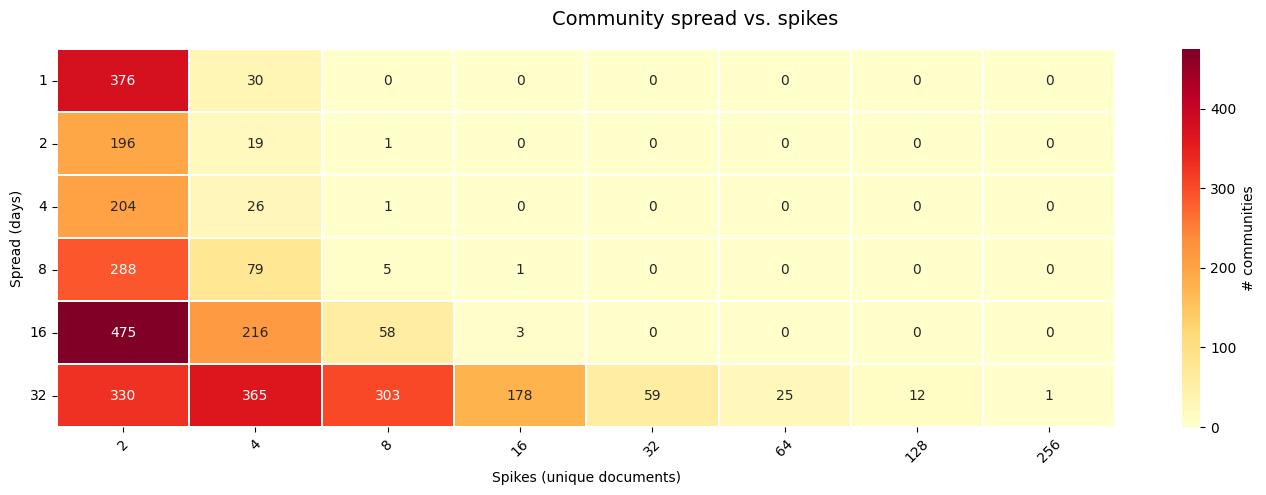

In [74]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))

df = pd.DataFrame(dict(spikes=spike_values, spread=spread_values))
df = df[[v < 85 for v in duplicate]]
# remove single spikes
df = df[df.spikes > 1]  

log_base = 2
df["floored_log_spread"] = np.floor(np.emath.logn(log_base, df.spread))
df["floored_log_spikes"] = np.floor(np.log2(df.spikes))

# Pivot to a 2D count matrix
heat = (
    df.groupby(["floored_log_spread", "floored_log_spikes"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# Readable tick labels: use bin midpoints
x_labels = [f"{int(2 ** b)}" for b in heat.columns]
y_labels = [f"{int(log_base ** b)}" for b in heat.index]

sns.heatmap(
    heat,
    ax=ax,
    cmap="YlOrRd",
    xticklabels=x_labels,
    yticklabels=y_labels,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "# communities"},
    annot=True,
    fmt="d",
)

ax.set_xlabel("Spikes (unique documents)")
ax.set_ylabel("Spread (days)")
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", rotation=0)

plt.suptitle("Community spread vs. spikes", fontsize=14)
plt.tight_layout()
plt.show()

In [72]:
def activation_score(comm, contexts):
    """A score function to surface those micro-narratives that are the strongest activated in across their contexts"""
    members = {e.id for e in comm.members}
    scores = []
    for context in contexts:
        activated = {e.id for tuplet in context.tuplets
                     for e in [tuplet.entity_one, tuplet.entity_two]}
        scores.append(len(activated) / len(members))
    return np.mean(scores)

def slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    sliced_df = df[
        (min_spread <= df.spread) & 
        (df.spread < max_spread) & 
        (min_spikes <= df.spikes) & 
        (df.spikes < max_spikes)
        ]
    print('Number of comms:', len(sliced_df))
    micro_narratives = [k_clique_comms_with_contexts[row[0]] for row in sliced_df.iterrows()]
    micro_narratives.sort(key=lambda tpl: activation_score(*tpl), reverse=True)
    return micro_narratives
    

def print_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    for comm, context in slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
        print_comm_with_contexts(comm, context)

In [ ]:
spread_boundary = 

### Same day or within a week, two or three spikes: quote+response, similar comment or point

In [73]:
print_micro_narratives(1, 2, 2, 4)

Number of comms: 376
COMMUNITY: an academic force, a great equalizer, Any depth, our collective mind, particular deficiencies
ID: 38396, OFFSET: 0
ChatGPT is an academic force multiplier. Not only that, it will also be a great equalizer for those with particular deficiencies. It won't just make things easier for everyone, it will also broaden the depth of our collective mind.

I understand why people are fearful, but you're right, this is just another step up a staircase upon which we've already reached fatal heights. 


ID: 38495, OFFSET: 0
&gt; ChatGPT is an academic force multiplier. Not only that, it will also be a great equalizer for those with particular deficiencies. It won't just make things easier for everyone, it will also broaden the depth of our collective mind.

It will do nothing of the kind.  This isn't like the printing press replacing scribes, where the real purpose was to produce a book and the press created them more efficiently, albeit at the cost of the scribes' em

In [109]:
print_micro_narratives(2, 8, 2, 4)

Number of comms: 185
COMMUNITY: undergraduate papers, an old friend, a tenured professor, his department, a cat and mouse game
ID: 37712, OFFSET: 327
You don't need to bother; an old friend who's a tenured professor told me his department is ceasing to assign undergraduate papers this year. Because this tech crossed their threshold for being better at writing papers at this level than the average frosh.
ID: 37815, OFFSET: 0
&gt;You don't need to bother; an old friend who's a tenured professor told me his department is ceasing to assign undergraduate papers this year.

It's funny because people in this thread are discussing the cat and mouse game when this solution immediately pops up. If AI gets too good, they'll just stop assigning papers, and people that cheat will be completely fucked.

COMMUNITY: the interaction, a new life Form, your other point, general intelligence
ID: 32961, OFFSET: 230
And to your other point. I believe only through general intelligence we can create a new lif

### More than a week, two or three spikes: similar comment or point, common entities being discussed

In [113]:
print_micro_narratives(8, 14, 2, 4)

Number of comms: 111
COMMUNITY: a new language, their pocket, a super computer
ID: 6440, OFFSET: 155
Now, everyone has a super computer in their pocket that can do mathematics, keep track of their calendar , teach them new languages , etc.
ID: 36089, OFFSET: 405
because the reality is mental arithmetic is useless now because people have super computers in their pocket. If the same happens with writing pros then we need to move our education system away from teaching that as heavily.

COMMUNITY: Kodak, the business model, a pioneer
ID: 12757, OFFSET: 22
Kodak was a pioneer of digital photography as well. They did not promote it because they were happy with their existing business model.
ID: 34353, OFFSET: 66
That's why they're treading cautiously because if you give users  a system that provides near perfect answers and they don't go around clicking a bunch of links it kinda breaks you're business model.

I see this as a Kodak Digital  vs. Kodak film crossroads, do you create a better s

In [114]:
print_micro_narratives(14, 100, 2, 4)

Number of comms: 397
COMMUNITY: some sci-fi shit, our thoughts, our minds
ID: 22904, OFFSET: 126
That said, playing with ChatGPT really makes you wonder how many of our thoughts and feeling are "native" and how many are influenced/generated by the narratives we build in our minds.
ID: 33337, OFFSET: 0
Eventually the AI will infiltrate our minds and create our thoughts for us or some sci-fi shit.
ID: 33338, OFFSET: 0
Eventually the AI will infiltrate our minds and create our thoughts for us or some sci-fi shit.

COMMUNITY: the current time, What a time, your device
ID: 19842, OFFSET: 1707
What time is it? 

I am a machine learning model, I do not have the ability to know the current time.
If you are looking for the current time, you can check the time on your device or check a time website or service.
ID: 47349, OFFSET: 0
It is not connected to the Internet, and it doesn't have access to the current time, so how would it know to add 1 year, and not 2 or 3. Just ask it "what time is it" 

### Same day or within a week, multiple spikes: common theme discussions

In [110]:
print_micro_narratives(1, 2, 4, 100)

Number of comms: 6
COMMUNITY: a scientific perspective, an engineer, an engineering perspective, Yann, a scientist, the perspective
ID: 44647, OFFSET: 0
It is revolutionary from an engineering perspective; but only evolutionary from a scientific perspective. Yann is a scientist more than an engineer so comes at it with that perspective.
ID: 44650, OFFSET: 0
From an engineering perspective it is revolutionary; from a scientific perspective it is evolutionary.
ID: 44652, OFFSET: 0
It is revolutionary from an engineering perspective; but only evolutionary from a scientific perspective. Yann is a scientist more than an engineer so comes at it with that perspective.
ID: 44768, OFFSET: 0
It is revolutionary from an engineering perspective; but only evolutionary from a scientific perspective. Yann is a scientist more than an engineer so comes at it with that perspective.
ID: 44786, OFFSET: 45
There are people who advance theory and those who advance practice and Yann is looking at this invent

In [111]:
print_micro_narratives(2, 8, 4, 100)

Number of comms: 25
COMMUNITY: a good wage, 30$ and hour, California
ID: 46071, OFFSET: 0
30$ and hour is not out on the street wages in California. That’s bullshit.
ID: 46138, OFFSET: 136
But California is huge. And while it is expensive, 30$ and hour in a majority of the state is not living on the streets money
ID: 46163, OFFSET: 0
All I’m saying is that 30$ and hour is a good and livable wage in large parts of California. Which is true. 

But it’s not true for the major metro areas.
ID: 46168, OFFSET: 38
In California. 

It’s expensive here for sure. But 30$ and hour is a good wage where I live. In California

COMMUNITY: math courses, open book, an exam, any other exams
ID: 36067, OFFSET: 0
In my engineering classes, we couldn’t use a calculator in our first few math classes and such, but eventually every exam is open book, with programming and calculators. At a point, the problems are complex enough you can’t plug them into a calculator. The exams are challenging enough that no tex

### More than a week, multiple spikes: recurring themed discussions, sticky comments/points

In [115]:
print_micro_narratives(8, 14, 4, 100)

Number of comms: 30
COMMUNITY: Discord, the servers, the specific image, credit card
ID: 8758, OFFSET: 0
Discord, And no you can't link to something in discord without being in the server yourself. Otherwise it won't go through.

https://discord.com/channels/974519864045756446/977259063052234752/1062169050827984956


ID: 8873, OFFSET: 0
I see, if you’re willing to download a program called Discord, that’s how they are communicating. There is likely a server for their company that interfaces with the public.

I’m not sure where the link for the Discord is, and I checked their website and there isn’t an obvious way to contact them otherwise.


ID: 19524, OFFSET: 311
The API is able to access the specific image on Discord because it is able to reach the server where the image is hosted. However, if the server is down, the API is not able to retrieve the information and the link will not work.
ID: 21473, OFFSET: 349
Just needs an API key from OpenAI you can get here: [https://beta.openai.c

In [116]:
print_micro_narratives(14, 100, 4, 100)

Number of comms: 382
COMMUNITY: AMP, OP, the Open Web](https://www.reddit.com/r/AmputatorBot/comments, the canonical page, About)](https://www.reddit.com, /r/AmputatorBot/comments/ehrq3z/why_did_i_build_amputatorbot)^
ID: 42727, OFFSET: 0
It looks like you shared an AMP link. These should load faster, but AMP is controversial because of [concerns over privacy and the Open Web](https://www.reddit.com/r/AmputatorBot/comments/ehrq3z/why_did_i_build_amputatorbot).

Maybe check out **the canonical page** instead: **[https://nypost.com/2005/10/22/degree-of-stupidity-wal-mart-heir-head-cheated-at-usc/](https://nypost.com/2005/10/22/degree-of-stupidity-wal-mart-heir-head-cheated-at-usc/)**

*****

 ^(I'm a bot | )[^(Why &amp; About)](https://www.reddit.com/r/AmputatorBot/comments/ehrq3z/why_did_i_build_amputatorbot)^( | )[^(Summon: u/AmputatorBot)](https://www.reddit.com/r/AmputatorBot/comments/cchly3/you_can_now_summon_amputatorbot/)
ID: 49253, OFFSET: 0
It looks like you shared an AMP link. 